In [195]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from sklearn.metrics import r2_score
import seaborn as sns
from pmdarima.arima import auto_arima

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [158]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,BatchIndex,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
0,0,-0.260848,0.123912,0.937022,25.2,108.666275
1,1,-0.344876,0.116629,1.033851,26.9,109.853065
2,2,-0.339656,0.115659,1.027957,27.9,112.921150
3,3,-0.317045,0.126365,0.993998,28.6,112.257874
4,4,-0.284570,0.122794,0.971008,25.3,112.399788


<Axes: >

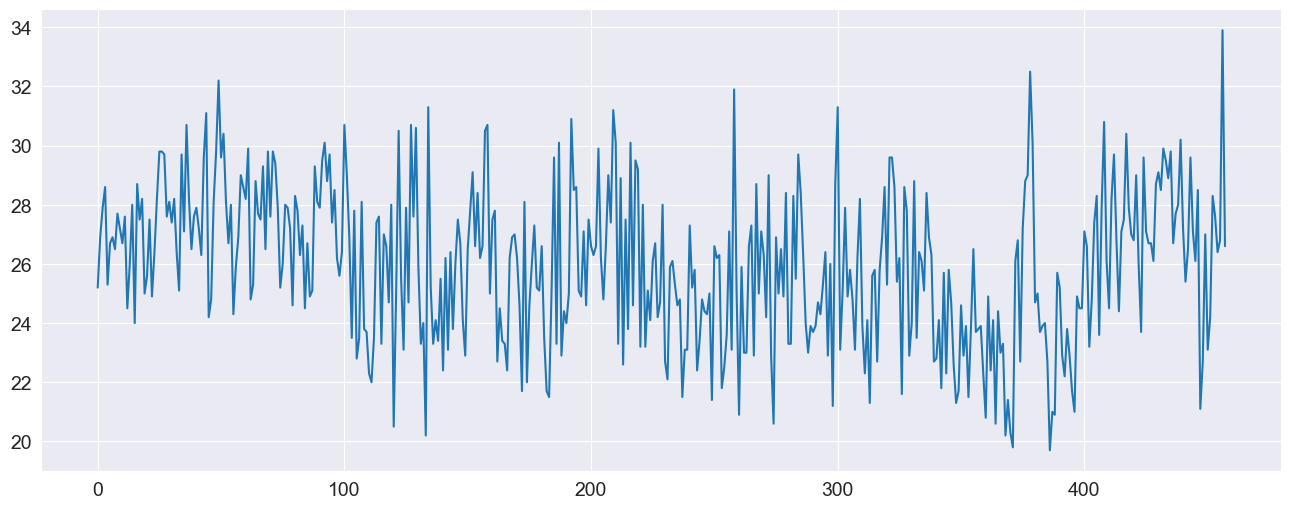

In [159]:
data15.CUM_Steam.plot()

## QQ Plot

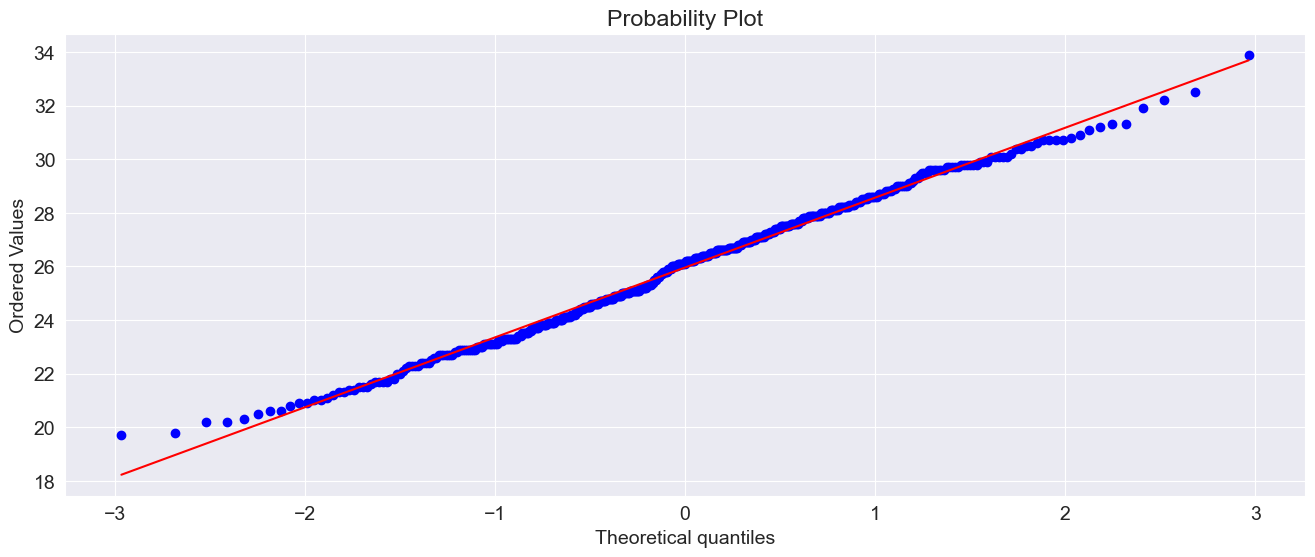

In [160]:
scipy.stats.probplot(data15.CUM_Steam, plot=pylab)
pylab.show()

In [161]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['BatchIndex'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [162]:
data15.head()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 00:00:00,-0.260848,0.123912,0.937022,25.2,108.666275
2023-01-01 00:01:00,-0.344876,0.116629,1.033851,26.9,109.853065
2023-01-01 00:02:00,-0.339656,0.115659,1.027957,27.9,112.921150
2023-01-01 00:03:00,-0.317045,0.126365,0.993998,28.6,112.257874
2023-01-01 00:04:00,-0.284570,0.122794,0.971008,25.3,112.399788


In [163]:
data15_train = data15[:412]
data15_test = data15[412:]

In [164]:
data15_train.tail()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 06:47:00,-0.214339,0.007323,1.014626,27.9,95.201584
2023-01-01 06:48:00,-0.583381,0.136749,1.215810,30.8,95.179120
2023-01-01 06:49:00,-0.359145,0.132851,1.018535,26.1,95.548090
2023-01-01 06:50:00,-0.212672,0.132671,0.838498,24.5,95.176450
2023-01-01 06:51:00,-0.275103,0.022933,0.896457,28.2,95.168365


In [165]:
data15_test.head

<bound method NDFrame.head of                         Delta  Damkohler     Sigma  CUM_Steam  Woodloading
Time                                                                      
2023-01-01 06:52:00 -0.279108   0.129834  0.987864       29.7    95.179190
2023-01-01 06:53:00 -0.288021   0.138864  0.954996       26.8    93.540530
2023-01-01 06:54:00 -0.284720   0.145218  0.938413       24.4    96.737830
2023-01-01 06:55:00 -0.286299   0.129122  0.941070       27.1    97.097946
2023-01-01 06:56:00 -0.298729   0.129506  0.977630       27.5   119.443611
2023-01-01 06:57:00 -0.301572   0.119907  0.982622       30.4   119.783524
2023-01-01 06:58:00 -0.298558   0.143207  0.983130       27.9   113.750542
2023-01-01 06:59:00 -0.290024   0.131177  0.953827       27.0   115.094070
2023-01-01 07:00:00 -0.298151   0.133075  0.973398       26.8   115.286476
2023-01-01 07:01:00 -0.307432   0.125940  1.001226       29.0   115.359390
2023-01-01 07:02:00 -0.285483   0.136893  0.947714       26.0   100.71

### Stationarity

In [166]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.589252897357407,
 0.00013519121068810783,
 6,
 451,
 {'1%': -3.444932949082776,
  '5%': -2.867969899953726,
  '10%': -2.57019489663276},
 2018.1619851085152)

### ACF

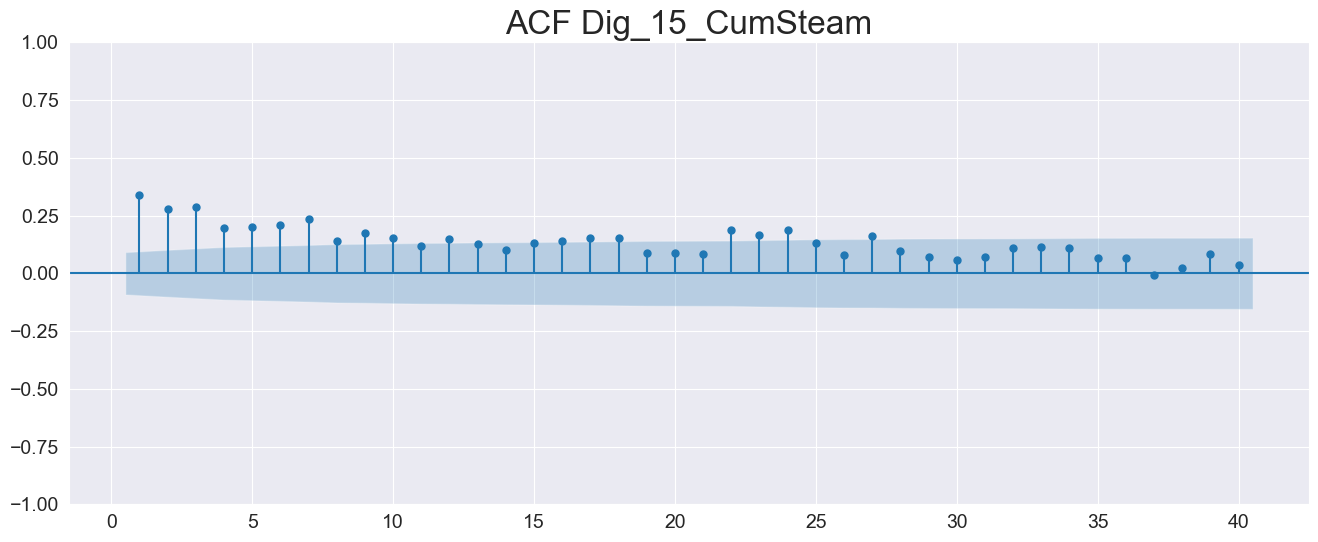

In [167]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("ACF Dig_15_CumSteam", size = 24)
plt.show()

### PACF

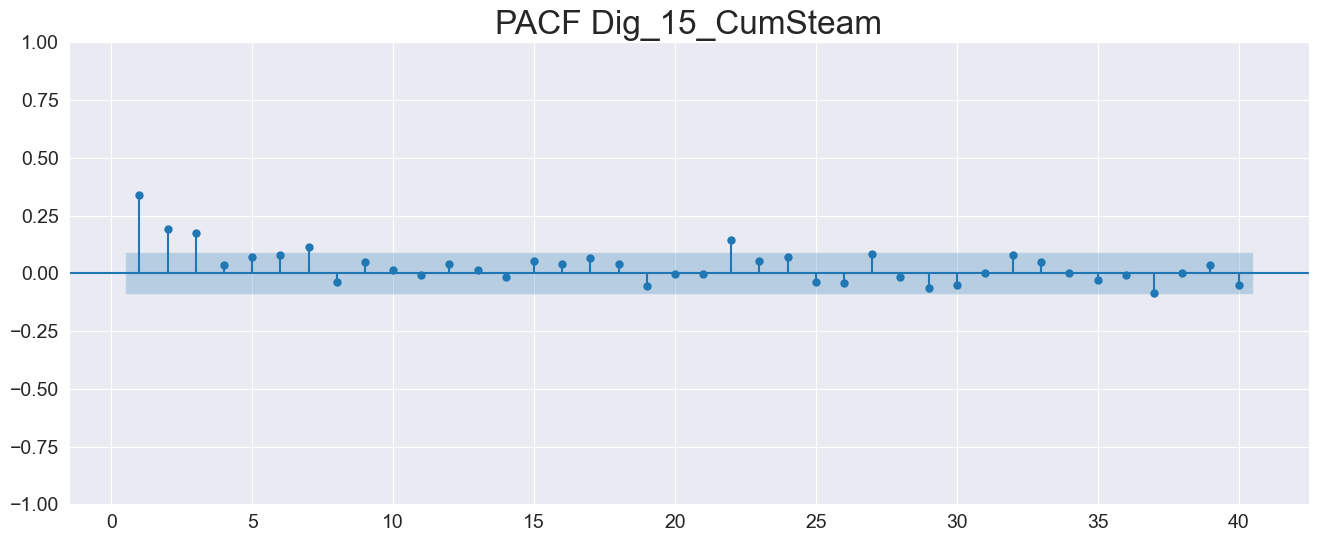

In [168]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_CumSteam", size = 24)
plt.show()

In [169]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p

### ARIMA Models

In [200]:
model_arima = ARIMA(data15_train.CUM_Steam, order=(3, 1, 1))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -934.722
Date:                Mon, 18 Mar 2024   AIC                           1879.444
Time:                        23:17:57   BIC                           1899.537
Sample:                    01-01-2023   HQIC                          1887.393
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1777      0.048      3.677      0.000       0.083       0.272
ar.L2          0.1076      0.045      2.386      0.017       0.019       0.196
ar.L3          0.0945      0.053      1.794      0.0

### ARIMA311 Training Plots

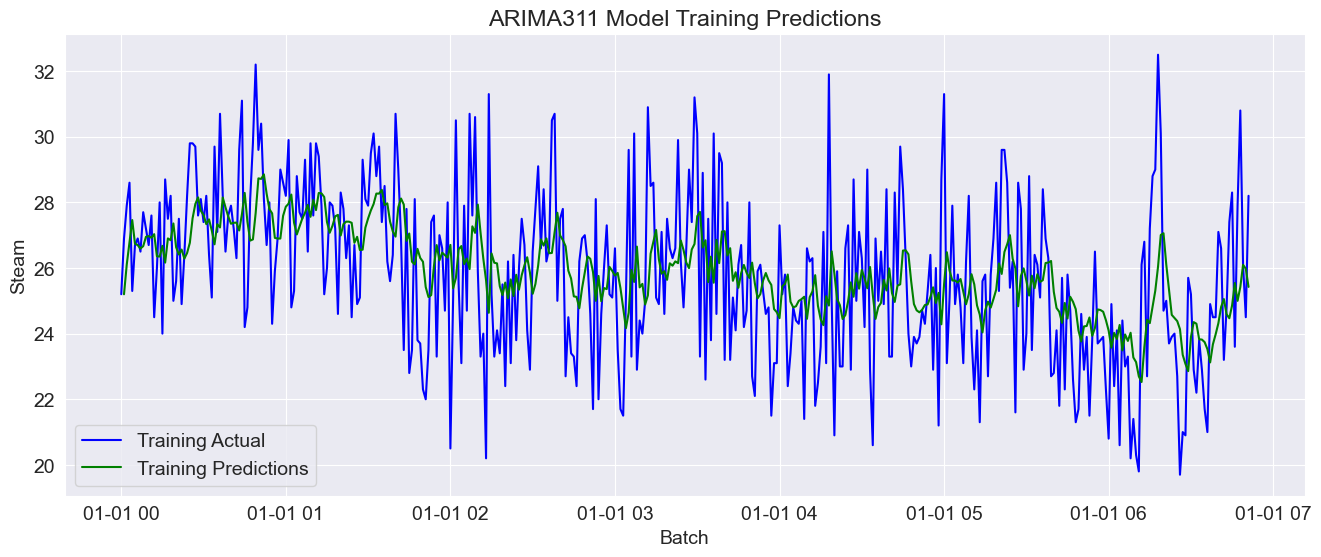

In [202]:
start_date = '2023-01-01 06:52:00'
end_date = '2023-01-01 07:37:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA311 Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMA311 Training Performance

In [203]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 2.6540662499358225
mae 1.980494912840921


### ARIMA311 Test Plots

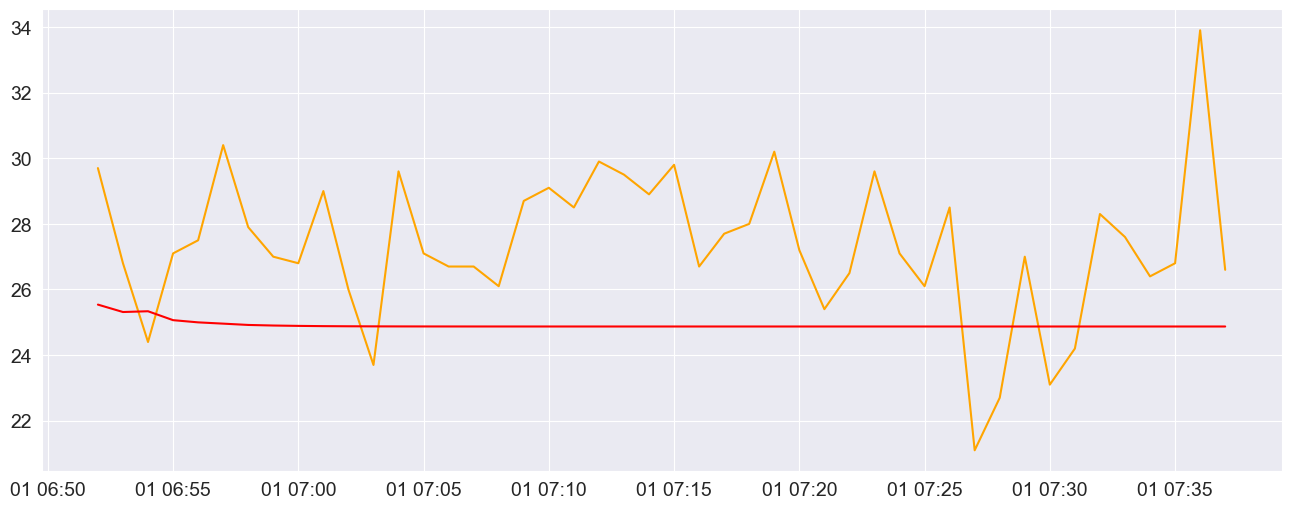

In [204]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMA311 Test Performance

In [205]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 3.303074650526589
mae 2.8777241543780643


### ARIMAX With Woodload

In [206]:
# Define exogenous variables
exog_vars = data15_train[['Woodloading']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(3,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -934.189
Date:                Mon, 18 Mar 2024   AIC                           1880.379
Time:                        23:29:47   BIC                           1904.490
Sample:                    01-01-2023   HQIC                          1889.917
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Woodloading    -0.0162      0.016     -1.011      0.312      -0.048       0.015
ar.L1           0.1722      0.049      3.526      0.000       0.076       0.268
ar.L2           0.1081      0.045      2.389      0.017       0.019       0.197
ar.L3           0.0873      0.053      1.645      0.100      -0.017       0.191
ma.L1          -0.9708      0.013    -74.199      0.000      -0.996      -0.945
sigma2          5.4901      0.436     12.594      0.000       4.636       6.345
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.70
Prob(Q):                              1.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.19   Skew:                             0.24
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX311 with Woodload Training Plots

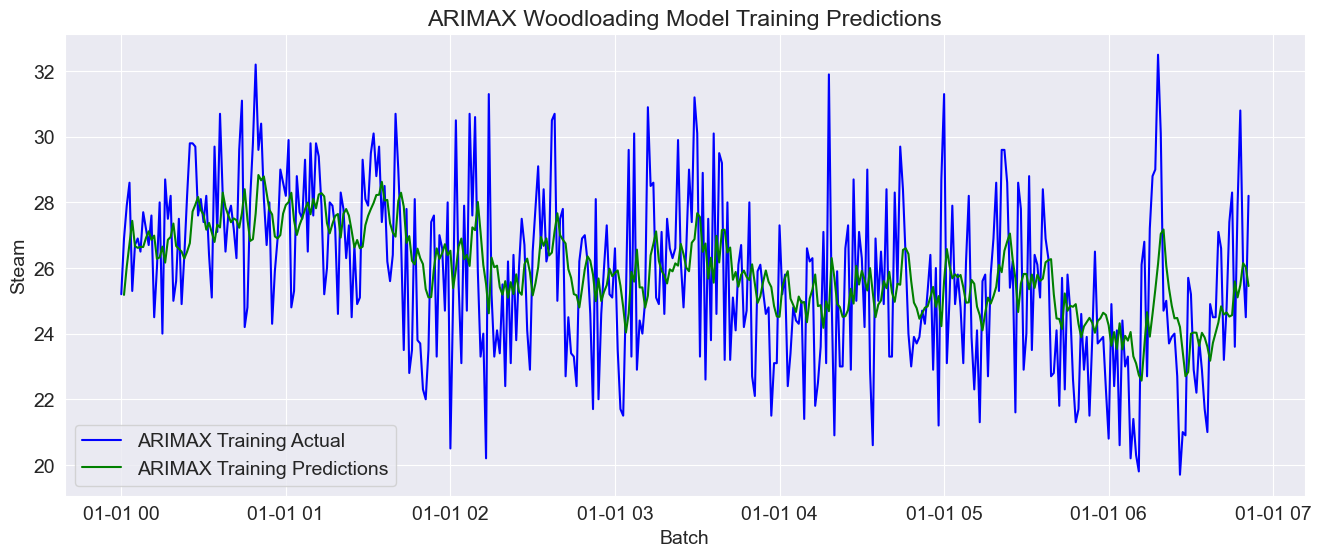

In [207]:
start_date = '2023-01-01 06:52:00'
end_date = '2023-01-01 07:37:00'
exog_vars_test = data15_test[['Woodloading']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Woodloading Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMAX311 Woodload Training Performance

In [208]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 2.6932895993583865
mae 1.9840274426608153


### ARIMAX with Woodload test plots

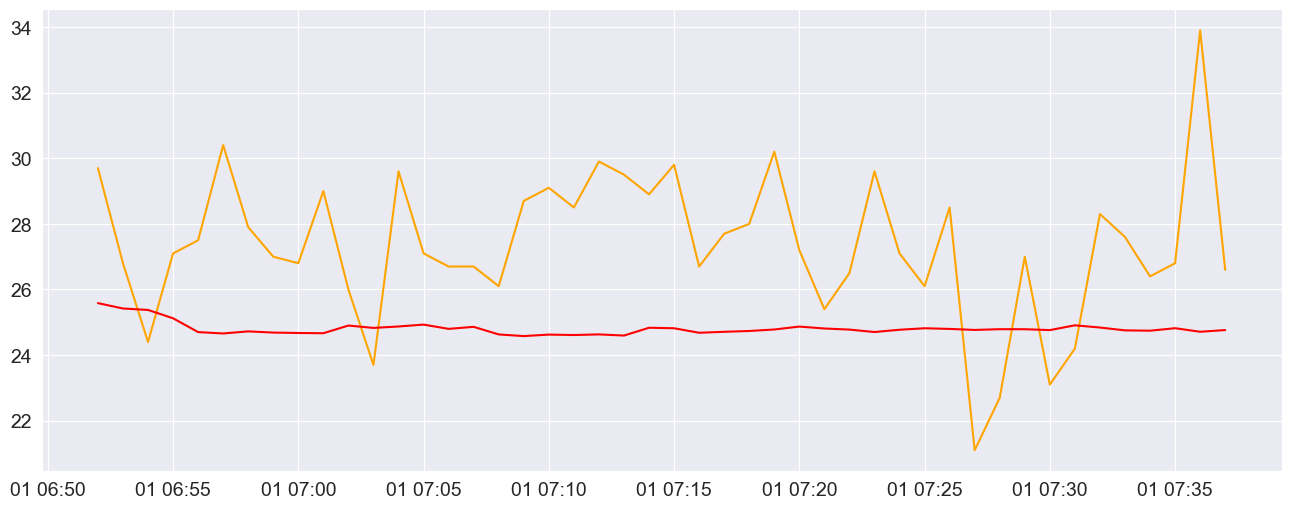

In [209]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMAX with Woodload test performance

In [210]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 3.4075845151576387
mae 2.9740902036231125


### ARIMAX with all Parameters

In [211]:
# Define exogenous variables
exog_vars = data15_train[['Delta', 'Damkohler', 'Sigma']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(3,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

c:\Users\USER\Documents\ARMods\linvenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -782.615
Date:                Mon, 18 Mar 2024   AIC                           1581.231
Time:                        23:39:11   BIC                           1613.380
Sample:                    01-01-2023   HQIC                          1593.949
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Delta         -1.9604      2.117     -0.926      0.354      -6.110       2.189
Damkohler      0.7988      3.046      0.262      0.793      -5.172       6.769
Sigma         14.2842      1.762      8.108      0.000      10.831      17.737
ar.L1          0.1418      0.053      2.668      0.008       0.038       0.246
ar.L2          0.1053      0.049      2.145      0.032       0.009       0.201
ar.L3          0.0337      0.052      0.645      0.519      -0.069       0.136
ma.L1         -0.9834      0.010    -97.066      0.000      -1.003      -0.964
sigma2         2.6171      0.204     12.815      0.000       2.217       3.017
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.94   Prob(JB):                         0.93
Heteroskedasticity (H):               0.91   Skew:                             0.04
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX311 with all parameters training plots

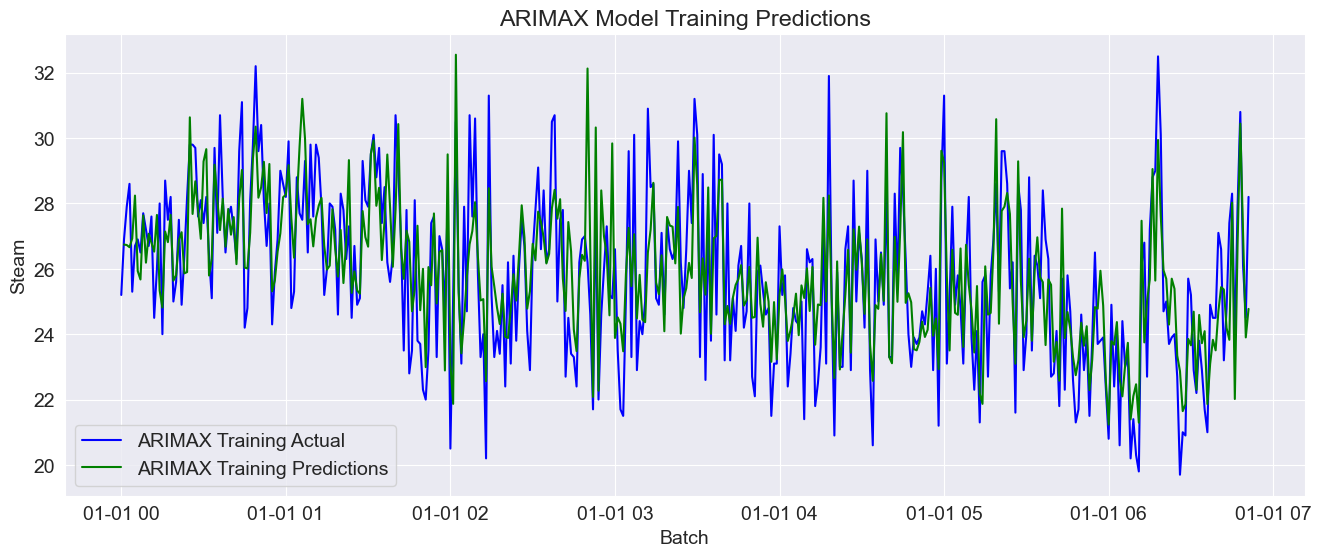

In [212]:
start_date = '2023-01-01 06:52:00'
end_date = '2023-01-01 07:37:00'
exog_vars_test = data15_test[['Delta', 'Damkohler', 'Sigma']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [213]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 1.7116331488157372
mae 1.3276220882131429


### ARIMAX test plots

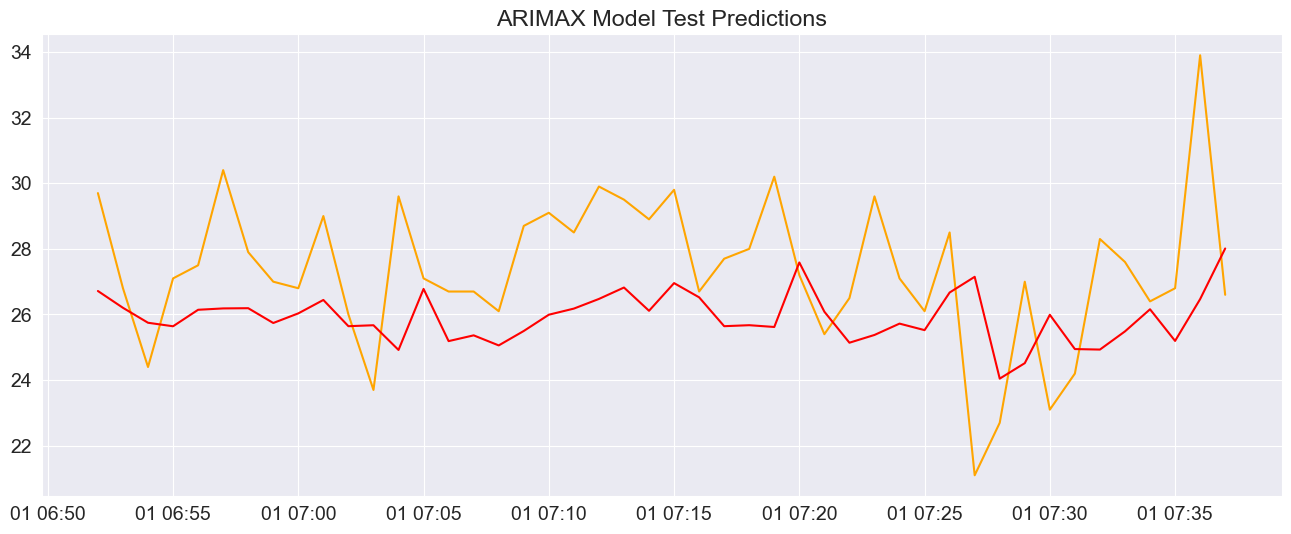

In [214]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Add labels and legend
plt.title('ARIMAX Model Test Predictions')

# Show plot
plt.show()

In [215]:
residuals = data15_train['CUM_Steam'] - train_predictions['predicted_mean']

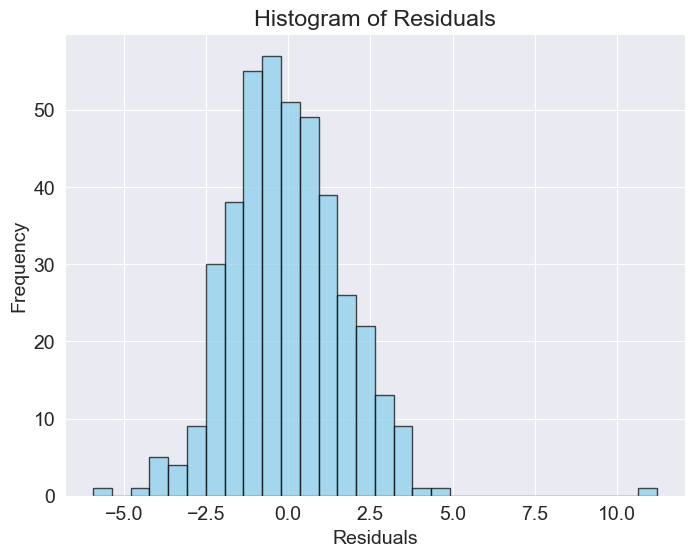

In [216]:
# Create a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Add a grid for better visualization
plt.grid(True)

# Show plot
plt.show()

### Test Performance

In [217]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 2.6430569911681077
mae 2.1542420606838677
